In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library(combinat)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
}))

source("helper_functions_for_diffex.r")


Loading required package: limma


Attaching package: 'limma'


The following object is masked from 'package:BiocGenerics':

    plotMA




# Definitions etc

In [2]:
set.seed(1234)
options(digits = 2)
stats <- c()


In [3]:
options(future.globals.maxSize = 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)


In [4]:
if (!exists("papermill_run")) {
    prj_name <- "Screen1_66guides"
    data_subdir_suffixes <- "L1,L2,L3,L4"
    secondary_a_path <- "S1/analysis/secondary/"
    save_seurat_h5 <- "NO"
}


In [5]:
custom_theme <- theme(
  plot.title = element_text(size = 16, hjust = 0.5),
  legend.key.size = unit(0.7, "cm"),
  legend.text = element_text(size = 14)
)


### Load Seurat file

In [6]:
integrated_h5_path <-
    "S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)
seurat_combined <- subset(seurat_combined, subset = status == "singlet")


Validating h5Seurat file



Warning message:
"Adding a command log without an assay associated with it"


Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [7]:
seurat_rna <- CreateSeuratObject(seurat_combined[["RNA"]])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data


### Load THRESHOLDS.tsv

In [8]:
thr_f_name <- paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds <- read.table(thr_f_name, header = T, strip.white = T)
df_thresholds <- df_thresholds %>%
    pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)


### Load guide df

In [9]:
df_guide <- read.table(
    "primary/S1_resources/66CRISPRi_ref_for_diffex.txt",
    sep = "\t", header = T, strip.white = T
)
head(df_guide)


,gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label,diffexed_gene
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CD13,CD13-1a,CD13-1b,ANPEP,tss,targeting,ANPEP,Control TSS,ANPEP
2,CD55,CD55-1a,CD55-1b,CD55,tss,targeting,CD55,Control TSS,CD55
3,CD73,CD73-1a,CD73-1b,NT5E,tss,targeting,NT5E,Control TSS,NT5E
4,FUBP1,FUBP1-1a,FUBP1-1b,FUBP1,tss,targeting,FUBP1,Control TSS,FUBP1
5,C15orf40,C15orf40-1a,C15orf40-1b,C15orf40,tss,targeting,C15orf40,Control TSS,C15orf40
6,MAFF,MAFF-1a,MAFF-1b,MAFF,tss,targeting,MAFF,Control TSS,MAFF


## FeaturePlot singlet & doublet

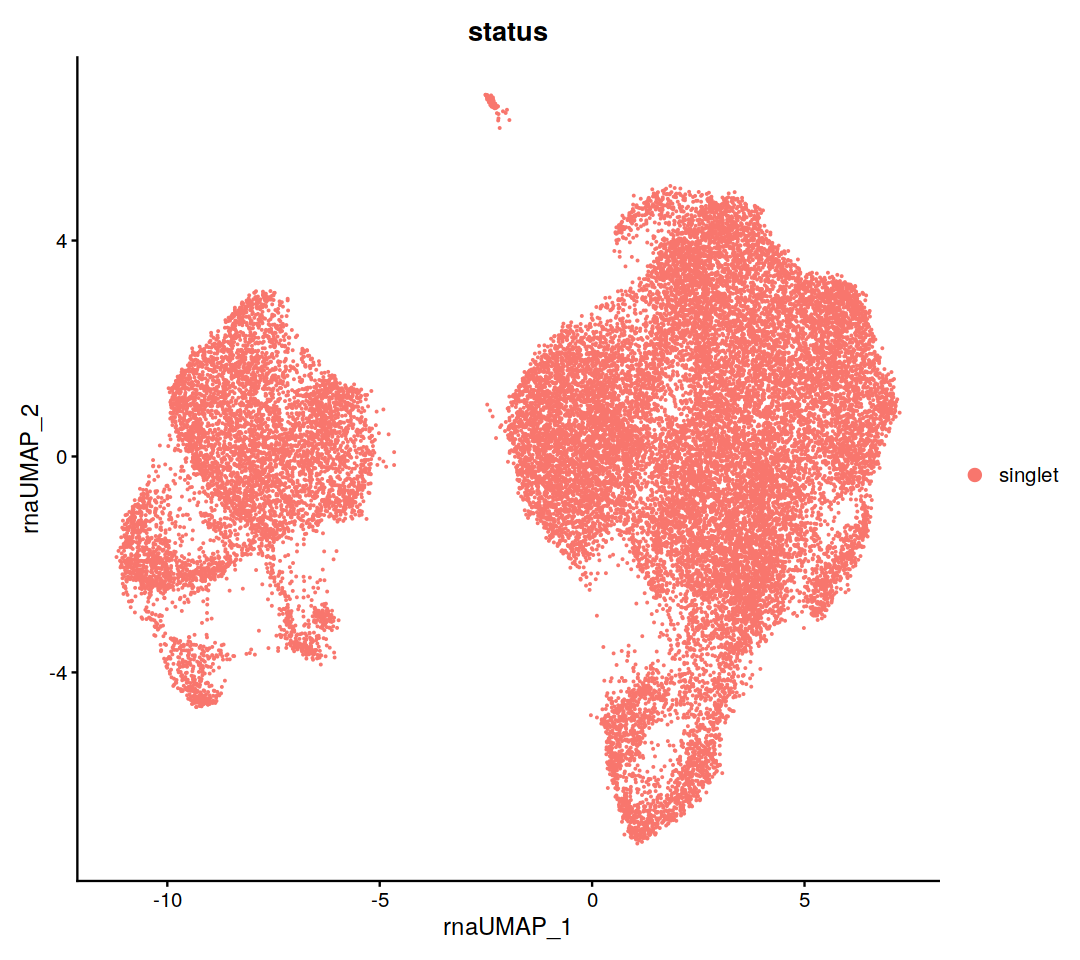

In [10]:
options(repr.plot.width = 9, repr.plot.height = 8)
DimPlot(seurat_combined, group.by = "status")


# Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [11]:
libraries <- unique(seurat_combined$library)
seurat_libs <- list()
for (i in seq_along(libraries)) {
    lib <- libraries[i]
    seurat_libs[[i]] <- subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries


In [12]:
perturbed_cells_by_guide <- list()

for (i in 1:nrow(df_thresholds)) {
    perturbed_cells_in_all_libs <- list()
    guide <- df_thresholds$guide[i]
    # Loop over libraries
    for (lib in libraries) {
        seurat_lib <- seurat_libs[[lib]]
        threshold <- df_thresholds[i, lib]
        # cat(blue(guide, lib, threshold, "\n"))
        cells_in_lib <- Cells(seurat_lib)
        sgrna_counts <- seurat_lib[["sgRNA"]]@counts
        select_perturbed <- sgrna_counts[guide, cells_in_lib] >= threshold
        perturbed_cells_in_library <- cells_in_lib[select_perturbed]
        perturbed_cells_in_all_libs <- append(
            perturbed_cells_in_all_libs, perturbed_cells_in_library
        )
    }
    perturbed_cells_by_guide[[i]] <- perturbed_cells_in_all_libs
}
names(perturbed_cells_by_guide) <- df_thresholds$guide


In [13]:
length(perturbed_cells_by_guide[[3]])


[1] 796

Find all unperturbed cells: these are the cells with either no guides or only NT guides

In [14]:
select_targeting_guides <- df_guide$class == "targeting"
df_targeting <- df_guide[select_targeting_guides, ]

targeting_guides <- c(df_targeting$guide1, df_targeting$guide2)
seurat_rna <- mark_target_pos_neg(
    seurat_rna,
    perturbed_cells_by_guide,
    targeting_guides
)
unperturbed_cells <- Cells(subset(seurat_rna, idents = "target_negative"))


CD13-1a   867 
CD55-1a   1605 
CD73-1a   2288 
FUBP1-1a   2887 
C15orf40-1a   3553 
MAFF-1a   4036 
FTH1-1a   4473 
FTH1-2a   6504 
PLIN3-1a   7037 
PLIN3-2a   7440 
TKT-1a   7792 
TKT-2a   8264 
LGALS3-1a   8732 
LGALS3-2a   9132 
CSTB-1a   9608 
CSTB-2a   10018 
CTSB-1a   10457 
CTSB-2a   10820 
KLF6-1a   11173 
KLF6-2a   11531 
DE1-1a   11841 
DE1-2a   12173 
DE2-1a   12174 
DE2-2a   12524 
DE3-1a   12860 
DE3-2a   13169 
DE4-1a   13674 
DE4-2a   13894 
DE5-1a   14182 
DE5-2a   14483 
DE6-1a   14720 
DE6-2a   15246 
DE7-1a   15507 
DE7-2a   15707 
DE8-1a   15950 
DE8-2a   16194 
DE9-1a   16418 
DE9-2a   16418 
DE10-1a   16562 
DE10-2a   16758 
DE11-1a   16967 
DE11-2a   17140 
DE12-1a   17297 
DE12-2a   17444 
DE13-1a   17614 
DE13-2a   17746 
DE14-1a   17901 
DE14-2a   18063 
DE15-1a   18222 
DE15-2a   18389 
DE16-1a   18529 
DE16-2a   18529 
DE17-1a   18652 
DE17-2a   18775 
CD13-1b   18790 
CD55-1b   18802 
CD73-1b   18812 
FUBP1-1b   18824 
C15orf40-1b   18841 
MAFF-1b   18849 


# Split by donor, then run DE testing 

In [15]:
count_idents <- function(seurat_obj, idents) {
    length(Cells(subset(seurat_obj, idents = idents)))
}


In [16]:
library("rlist")
neighbors_list <- list.load(
    "primary/S1_resources/neighbors_list.rds"
)



Attaching package: 'rlist'


The following object is masked from 'package:S4Vectors':

    List




In [17]:
df_targeting <- unique(
    filter(df_guide, class == "targeting")[, c("alias", "gene_or_rsid")]
)
df_de <- NULL
test_use <- "LR" # "MAST" #"wilcox"
genes_to_skip <- c("CD55", "CSTB", "DE11")
genes_to_skip <- c()
donors <- sort(unique(seurat_rna$donor))
lfc_threshold <- 0.03

for (donor_id in donors) {
    seurat_donor <- subset(seurat_rna, subset = donor == donor_id)
    perturbed_cells_by_guide <-
        get_perturbed_cells(seurat_combined, df_thresholds, donor_id)

    cat(green("Running Donor#", donor_id, "\n"))
    for (i in 1:nrow(df_targeting)) {
        target <- df_targeting[i, "alias"]
        gene_or_rsid <- df_targeting[i, "gene_or_rsid"]
        neighbors <- neighbors_list[[gene_or_rsid]]
        guides_4_target <- get_guides_by_subclass(df_guide, "alias", target)
        cat(blue(target, ":"), paste(guides_4_target, collapse = ","), "\n")
        seurat_dummy <- mark_target_pos_neg(
            seurat_donor, perturbed_cells_by_guide, guides_4_target,
            print_counts = T
        )

        markers <- FindMarkers(
            object = seurat_dummy,
            features = neighbors,
            slot = "data",
            ident.1 = "target_positive",
            ident.2 = "target_negative",
            test.use = test_use,
            latent.vars = c("library"),
            logfc.threshold = lfc_threshold,
            verbose = FALSE
        )

        if (nrow(markers) == 0) {
            cat(red("No DE genes", target, "\n"))
            next
        }
        markers$de_gene <- rownames(markers)
        markers$target <- target
        markers$donor <- donor_id
        rownames(markers) <- NULL
        df_de <- rbind(df_de, markers)
    }
}


Running Donor# 0 
ANPEP : CD13-1a,CD13-1b 
CD13-1a   205 
CD13-1b   270 
Guide+ = 270 ; Guide- = 6744 
CD55 : CD55-1a,CD55-1b 
CD55-1a   187 
CD55-1b   253 
Guide+ = 253 ; Guide- = 6761 
NT5E : CD73-1a,CD73-1b 
CD73-1a   170 
CD73-1b   231 
Guide+ = 231 ; Guide- = 6783 
FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   175 
FUBP1-1b   229 
Guide+ = 229 ; Guide- = 6785 
C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   207 
C15orf40-1b   274 
Guide+ = 274 ; Guide- = 6740 
MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   169 
MAFF-1b   219 
Guide+ = 219 ; Guide- = 6795 
FTH1 : FTH1-1a,FTH1-2a,FTH1-1b,FTH1-2b 
FTH1-1a   126 
FTH1-2a   798 
FTH1-1b   843 
FTH1-2b   843 
Guide+ = 843 ; Guide- = 6171 
PLIN3 : PLIN3-1a,PLIN3-2a,PLIN3-1b,PLIN3-2b 
PLIN3-1a   184 
PLIN3-2a   365 
PLIN3-1b   423 
PLIN3-2b   476 
Guide+ = 476 ; Guide- = 6538 
TKT : TKT-1a,TKT-2a,TKT-1b,TKT-2b 
TKT-1a   173 
TKT-2a   366 
TKT-1b   414 
TKT-2b   475 
Guide+ = 475 ; Guide- = 6539 
LGALS3 : LGALS3-1a,LGALS3-2a,LGALS3-1b,LGALS3-2b 
LGALS3-1a   

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes DE5 
DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
DE6-1a   221 
DE6-2a   643 
DE6-1b   695 
DE6-2b   699 
Guide+ = 699 ; Guide- = 6315 
DE7 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
DE7-1a   239 
DE7-2a   405 
DE7-1b   460 
DE7-2b   512 
Guide+ = 512 ; Guide- = 6502 
DE8 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
DE8-1a   223 
DE8-2a   475 
DE8-1b   543 
DE8-2b   617 
Guide+ = 617 ; Guide- = 6397 
DE9 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
DE9-1a   197 
DE9-2a   197 
DE9-1b   264 
DE9-2b   264 
Guide+ = 264 ; Guide- = 6750 
DE10 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
DE10-1a   175 
DE10-2a   351 
DE10-1b   398 
DE10-2b   461 
Guide+ = 461 ; Guide- = 6553 
DE11 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
DE11-1a   257 
DE11-2a   447 
DE11-1b   502 
DE11-2b   555 
Guide+ = 555 ; Guide- = 6459 
DE12 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
DE12-1a   218 
DE12-2a   373 
DE12-1b   426 
DE12-2b   485 
Guide+ = 485 ; Guide- = 6529 
DE13 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
DE13-1a   196 
DE13-2a   326 
DE13-1b   328 
DE13-2b   371 
Guide+ = 

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes DE5 
DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
DE6-1a   187 
DE6-2a   537 
DE6-1b   581 
DE6-2b   583 
Guide+ = 583 ; Guide- = 5229 
DE7 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
DE7-1a   210 
DE7-2a   376 
DE7-1b   440 
DE7-2b   480 
Guide+ = 480 ; Guide- = 5332 
DE8 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
DE8-1a   215 
DE8-2a   427 
DE8-1b   503 
DE8-2b   574 
Guide+ = 574 ; Guide- = 5238 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes DE8 
DE9 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
DE9-1a   202 
DE9-2a   202 
DE9-1b   288 
DE9-2b   288 
Guide+ = 288 ; Guide- = 5524 
DE10 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
DE10-1a   162 
DE10-2a   328 
DE10-1b   369 
DE10-2b   415 
Guide+ = 415 ; Guide- = 5397 
DE11 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
DE11-1a   211 
DE11-2a   371 
DE11-1b   420 
DE11-2b   468 
Guide+ = 468 ; Guide- = 5344 
DE12 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
DE12-1a   186 
DE12-2a   343 
DE12-1b   388 
DE12-2b   451 
Guide+ = 451 ; Guide- = 5361 
DE13 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
DE13-1a   150 
DE13-2a   276 
DE13-1b   278 
DE13-2b   324 
Guide+ = 324 ; Guide- = 5488 
DE14 : DE14-1a,DE14-2a,DE14-1b,DE14-2b 
DE14-1a   193 
DE14-2a   360 
DE14-1b   419 
DE14-2b   468 
Guide+ = 468 ; Guide- = 5344 
DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
DE15-1a   179 
DE15-2a   366 
DE15-1b   413 
DE15-2b   475 
Guide+ = 475 ; Guide- = 5337 
DE16 : DE16-1a,DE16-2a,DE16-1b,DE16-2b 
DE16-1a   155 
DE16-2a   155 
DE16-1b   21

### Correct p-values by total number of comparisons

In [18]:
n_tests <- length(flatten(neighbors_list))
print(n_tests)
df_de$adjusted_p_val <- p.adjust(
    p = df_de$p_val,
    method = "bonferroni",
    n = n_tests
)


[1] 725


Write hits to file

In [18]:
# Some genes come up as differentially expressed all the time
# Filter those out, and write to another file
lfc <- gsub("\\.", "_", lfc_threshold)
de_f_name <- paste0(
    secondary_a_path,
    "/integrated/DE_outputs/DE_genes_by_donor_LFC_", lfc, "_UNFILTERED.tsv"
)
write.table(df_de, de_f_name, sep = "\t", quote = F, row.names = F)

funky_de_genes <- c(
    "HMOX1", "AL357507.1", "IFI27", "AL138828.1", "SQSTM1",
    "PLCG2", "PLIN2", "SAA1", "RARRES2", "CDKN1A"
)
# df_de <- filter(df_de, !(de_gene %in% funky_de_genes))

de_f_name <- paste0(
    secondary_a_path,
    "/integrated/DE_outputs/DE_genes_by_donor_LFC_",
    lfc,
    "_FILTERED.tsv"
)
write.table(df_de, de_f_name, sep = "\t", quote = F, row.names = F)



Attaching package: 'huxtable'


The following object is masked from 'package:ggpubr':

    font


The following objects are masked from 'package:crayon':

    bold, italic


The following objects are masked from 'package:Hmisc':

    contents, label, label<-


The following object is masked from 'package:scales':

    number_format


The following object is masked from 'package:ggplot2':

    theme_grey


The following object is masked from 'package:dplyr':

    add_rownames


The following object is masked from 'package:AnnotationDbi':

    contents


The following object is masked from 'package:Biobase':

    contents


The following objects are masked from 'package:GenomicRanges':

    width, width<-


The following objects are masked from 'package:IRanges':

    width, width<-


The following object is masked from 'package:S4Vectors':

    width


The following objects are masked from 'package:BiocGenerics':

    width, width<-




0 
1 


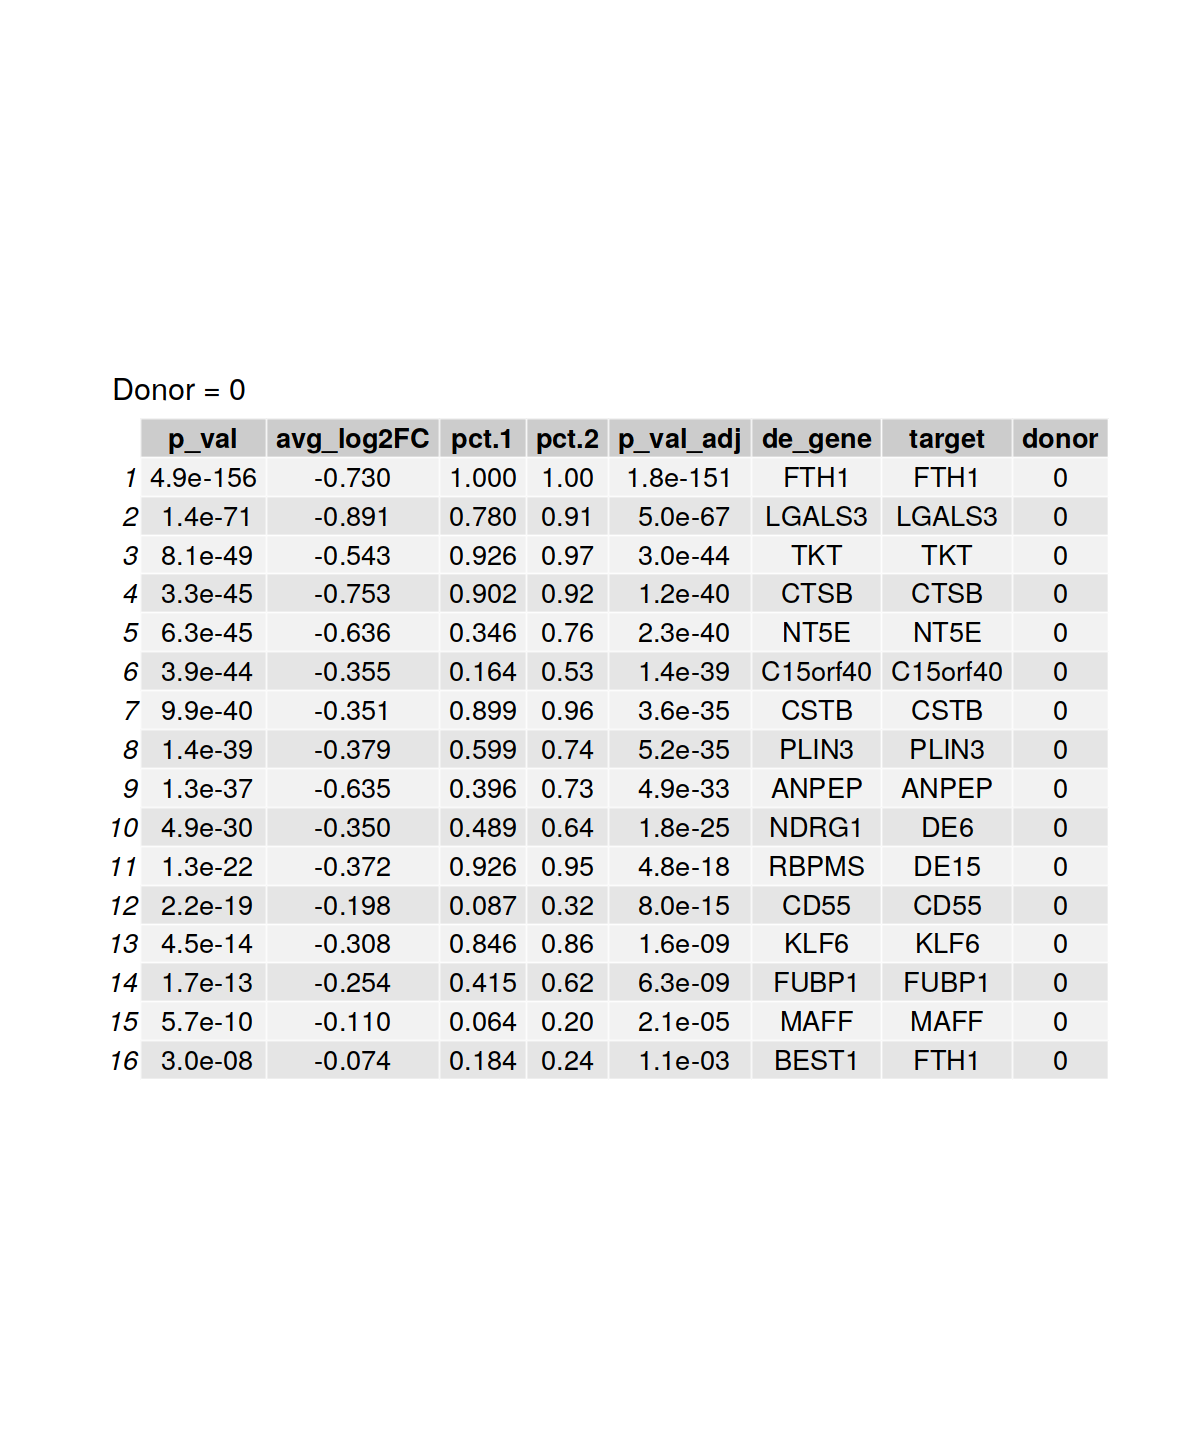

2 


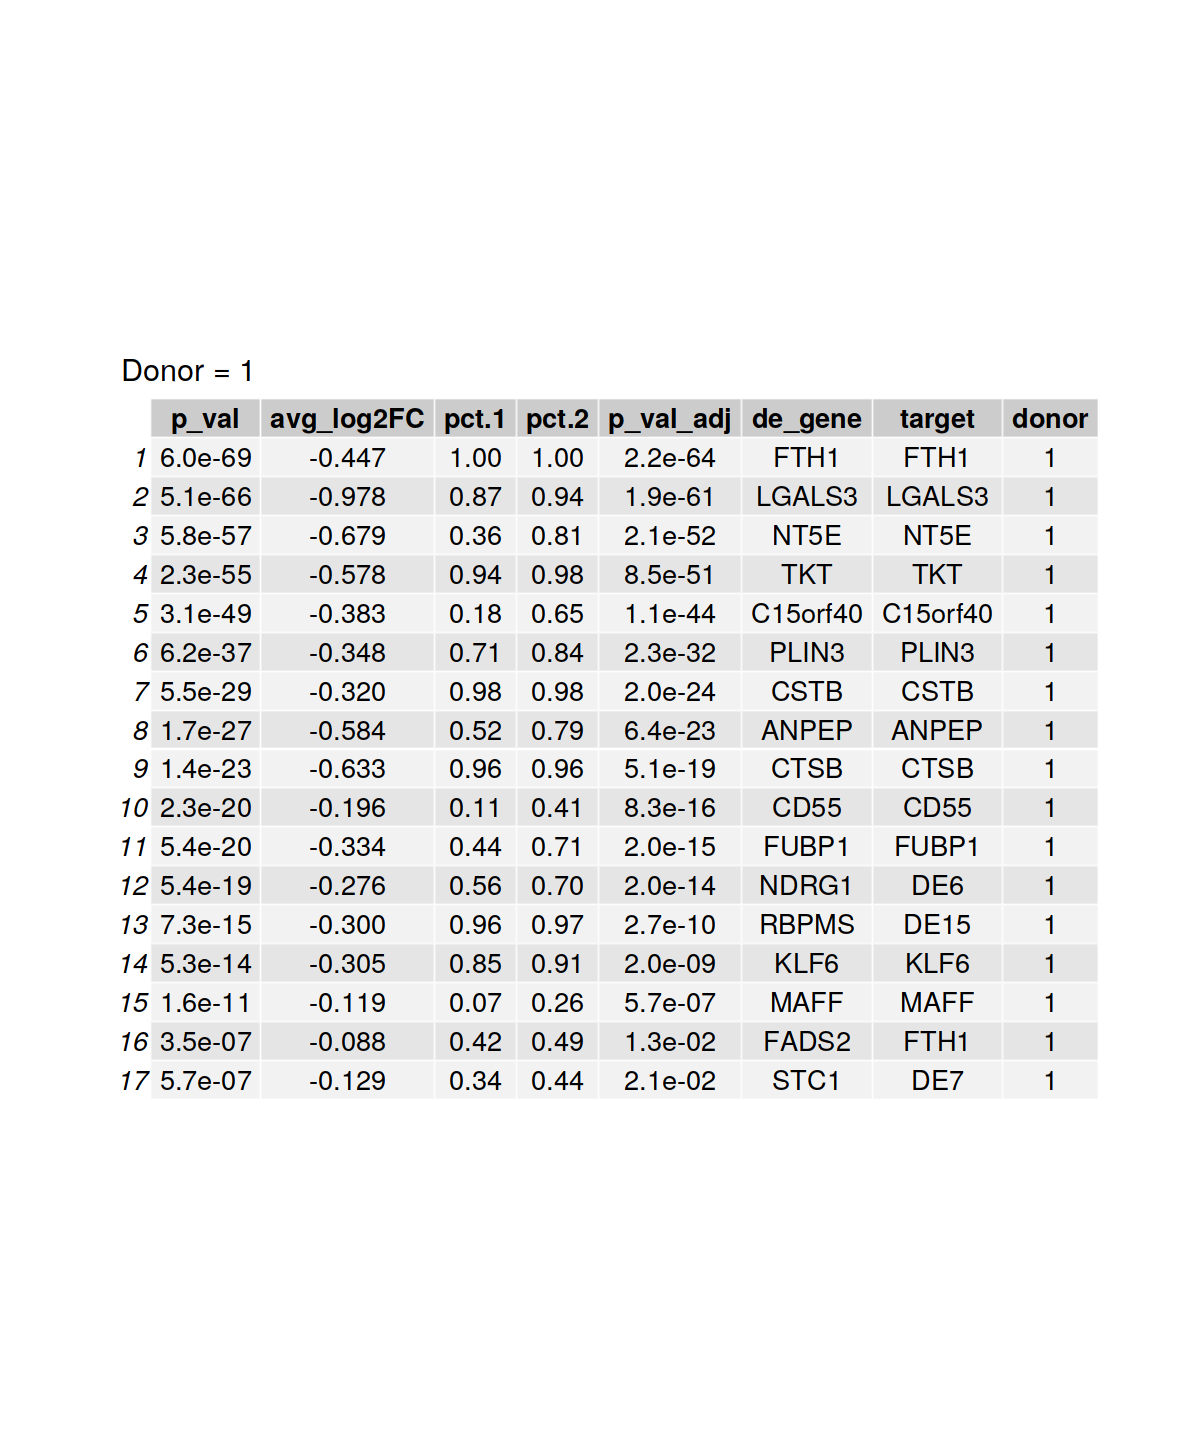

3 


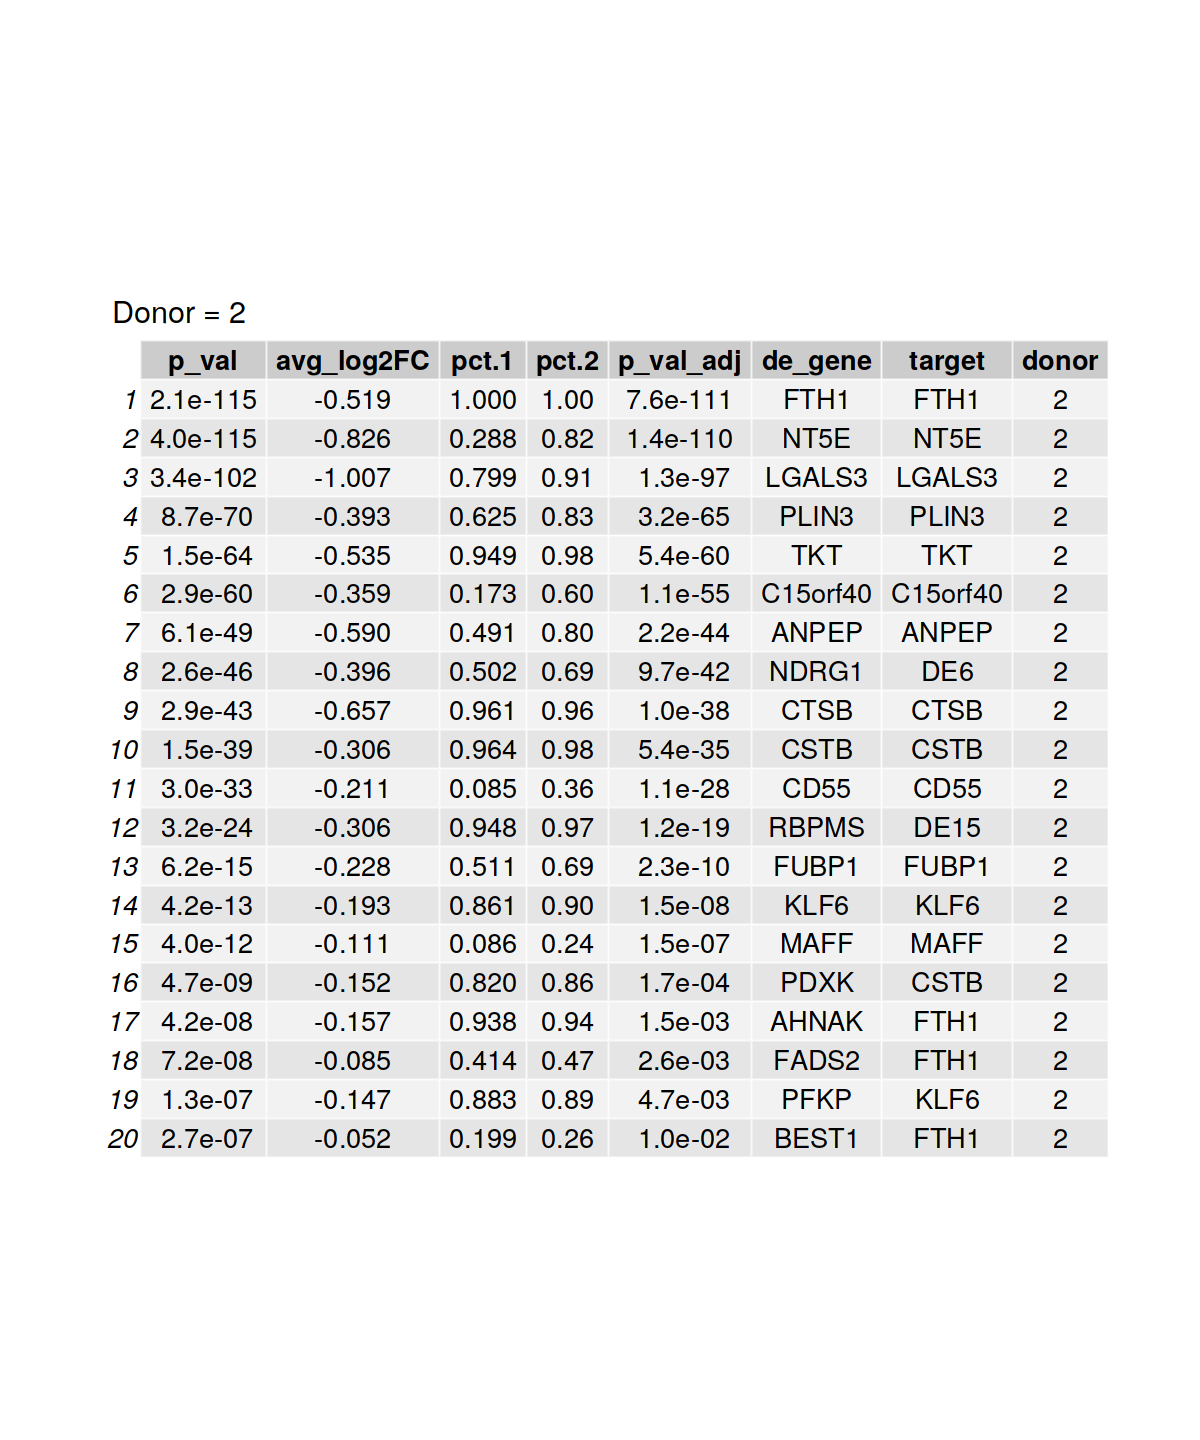

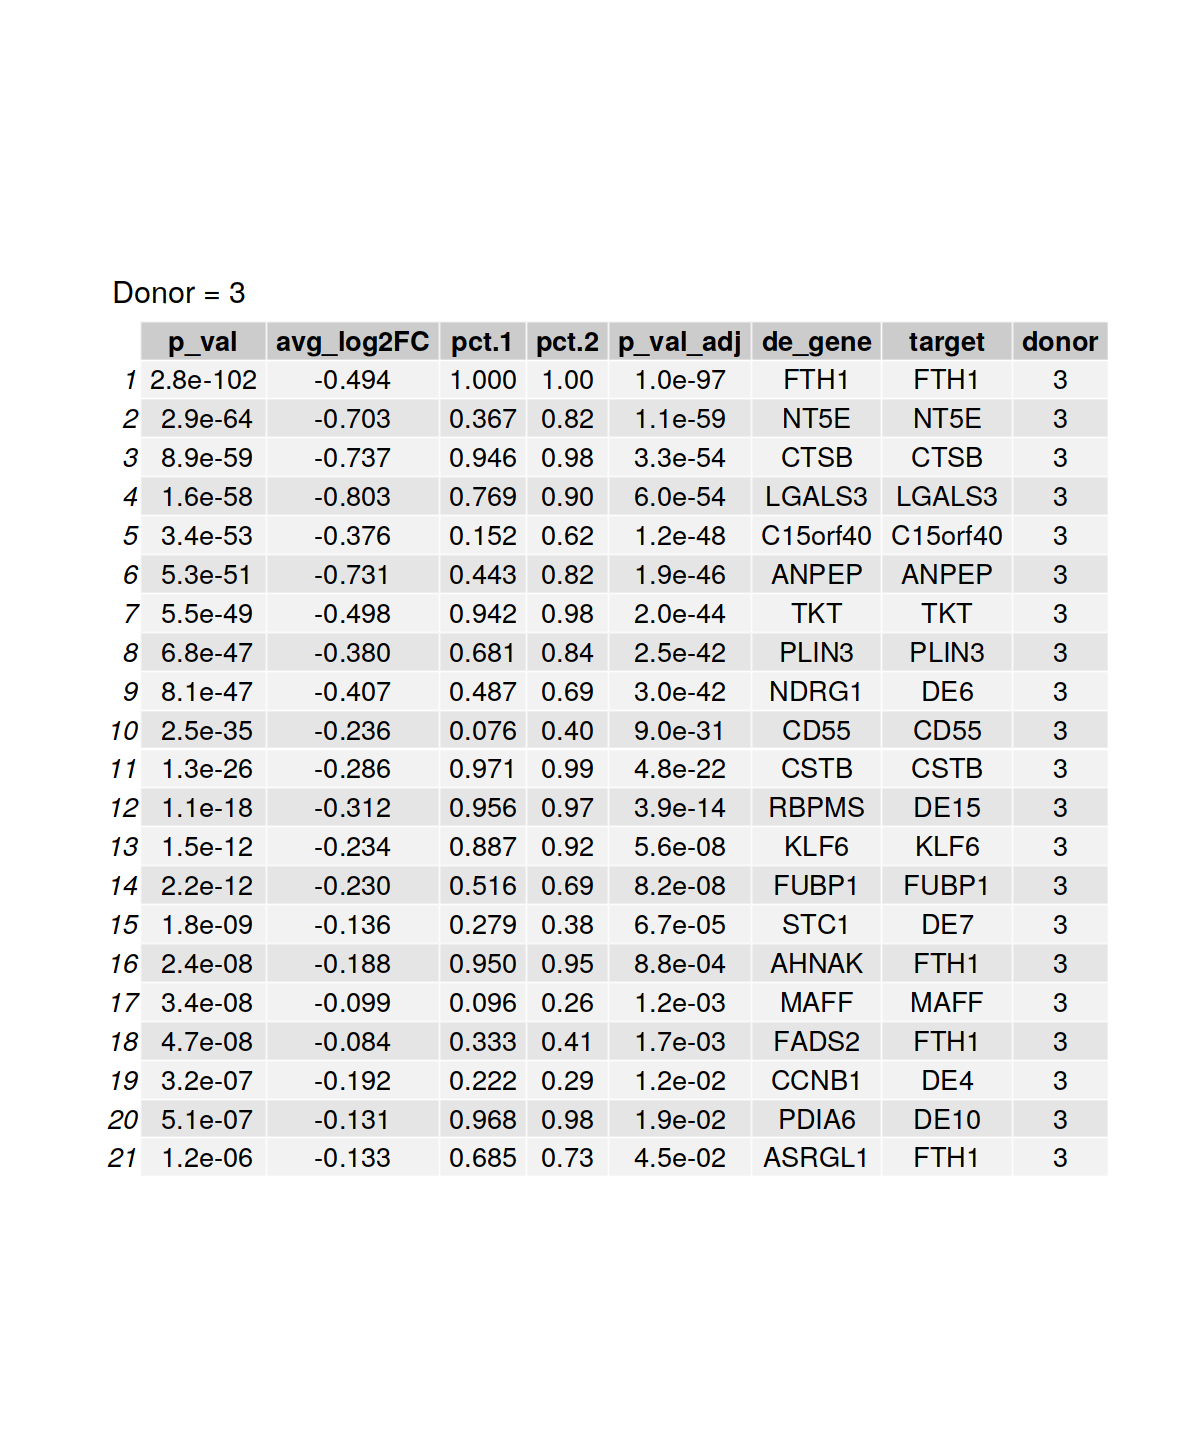

In [19]:
library(huxtable)
options(repr.plot.width = 10, repr.plot.height = 12)
for (donor_id in donors) {
    df_dummy <- df_de %>%
        filter(avg_log2FC < 0 & p_val_adj < 0.05) %>%
        filter(donor == donor_id) %>%
        arrange(p_val_adj) %>%
        head(30)
    cat(green(donor_id, "\n"))
    title <- paste0("Donor = ", donor_id)
    tb <- ggtexttable(
        df_dummy,
        theme = ttheme(base_size = 16)
    ) %>% tab_add_title(text = title, face = "plain", size = 18)
    print(tb)
}


## TSS controls

[1] "ANPEP"
CD13-1a   205 
CD13-1b   270 
Guide+ = 270 ; Guide- = 6744 
[1] "CD55"
CD55-1a   187 
CD55-1b   253 
Guide+ = 253 ; Guide- = 6761 
[1] "NT5E"
CD73-1a   170 
CD73-1b   231 
Guide+ = 231 ; Guide- = 6783 
[1] "FUBP1"
FUBP1-1a   175 
FUBP1-1b   229 
Guide+ = 229 ; Guide- = 6785 
[1] "C15orf40"
C15orf40-1a   207 
C15orf40-1b   274 
Guide+ = 274 ; Guide- = 6740 
[1] "MAFF"
MAFF-1a   169 
MAFF-1b   219 
Guide+ = 219 ; Guide- = 6795 
[1] "ANPEP"
CD13-1a   166 
CD13-1b   233 
Guide+ = 233 ; Guide- = 5579 
[1] "CD55"
CD55-1a   152 
CD55-1b   220 
Guide+ = 220 ; Guide- = 5592 
[1] "NT5E"
CD73-1a   169 
CD73-1b   215 
Guide+ = 215 ; Guide- = 5597 
[1] "FUBP1"
FUBP1-1a   131 
FUBP1-1b   166 
Guide+ = 166 ; Guide- = 5646 
[1] "C15orf40"
C15orf40-1a   157 
C15orf40-1b   210 
Guide+ = 210 ; Guide- = 5602 
[1] "MAFF"
MAFF-1a   144 
MAFF-1b   185 
Guide+ = 185 ; Guide- = 5627 


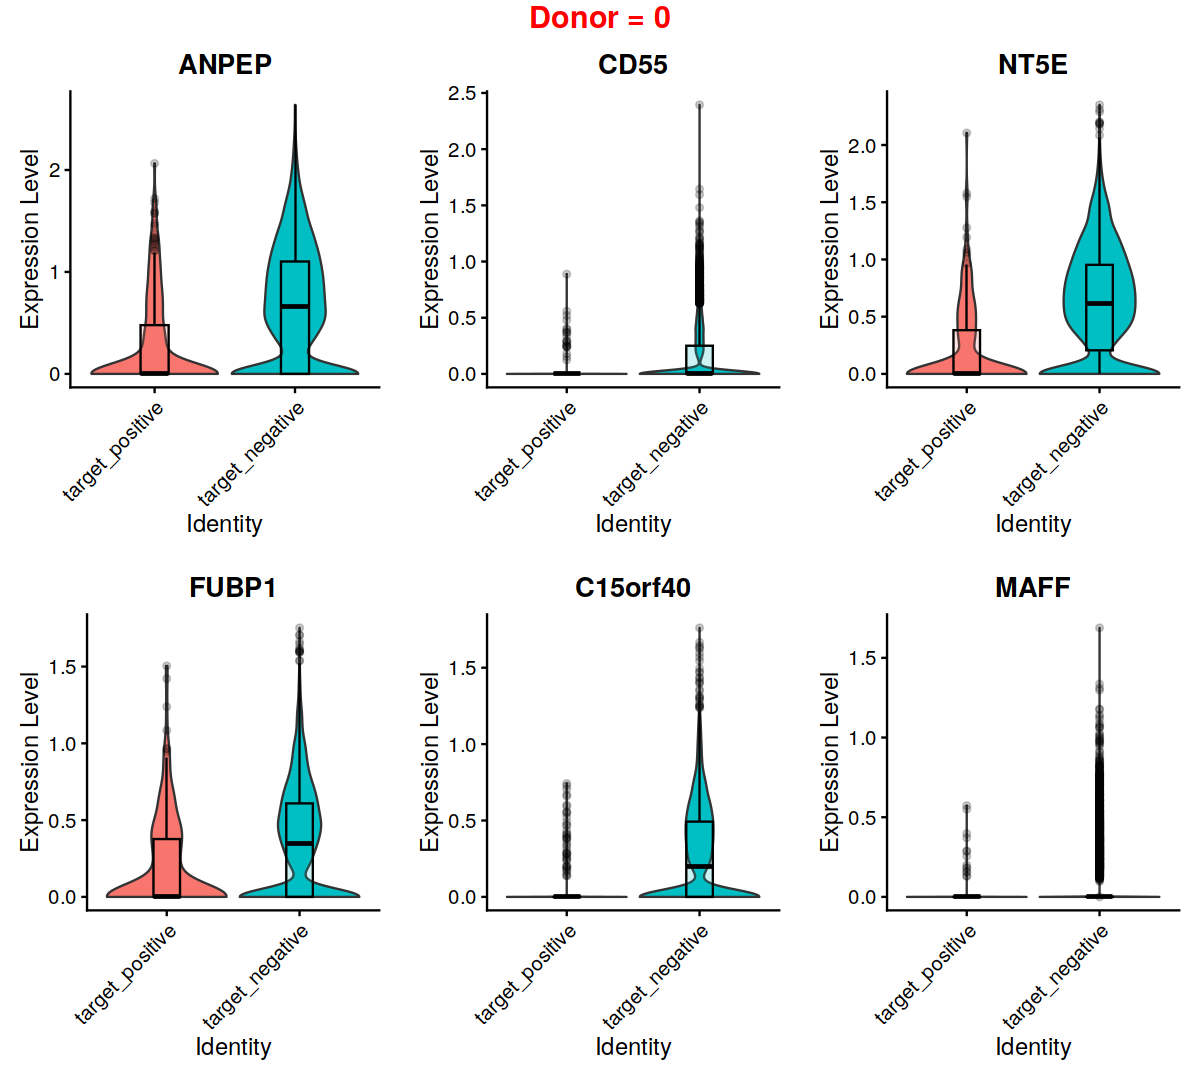

[1] "ANPEP"
CD13-1a   286 
CD13-1b   385 
Guide+ = 385 ; Guide- = 7687 
[1] "CD55"
CD55-1a   239 
CD55-1b   319 
Guide+ = 319 ; Guide- = 7753 
[1] "NT5E"
CD73-1a   244 
CD73-1b   337 
Guide+ = 337 ; Guide- = 7735 
[1] "FUBP1"
FUBP1-1a   217 
FUBP1-1b   282 
Guide+ = 282 ; Guide- = 7790 
[1] "C15orf40"
C15orf40-1a   257 
C15orf40-1b   323 
Guide+ = 323 ; Guide- = 7749 
[1] "MAFF"
MAFF-1a   195 
MAFF-1b   256 
Guide+ = 256 ; Guide- = 7816 


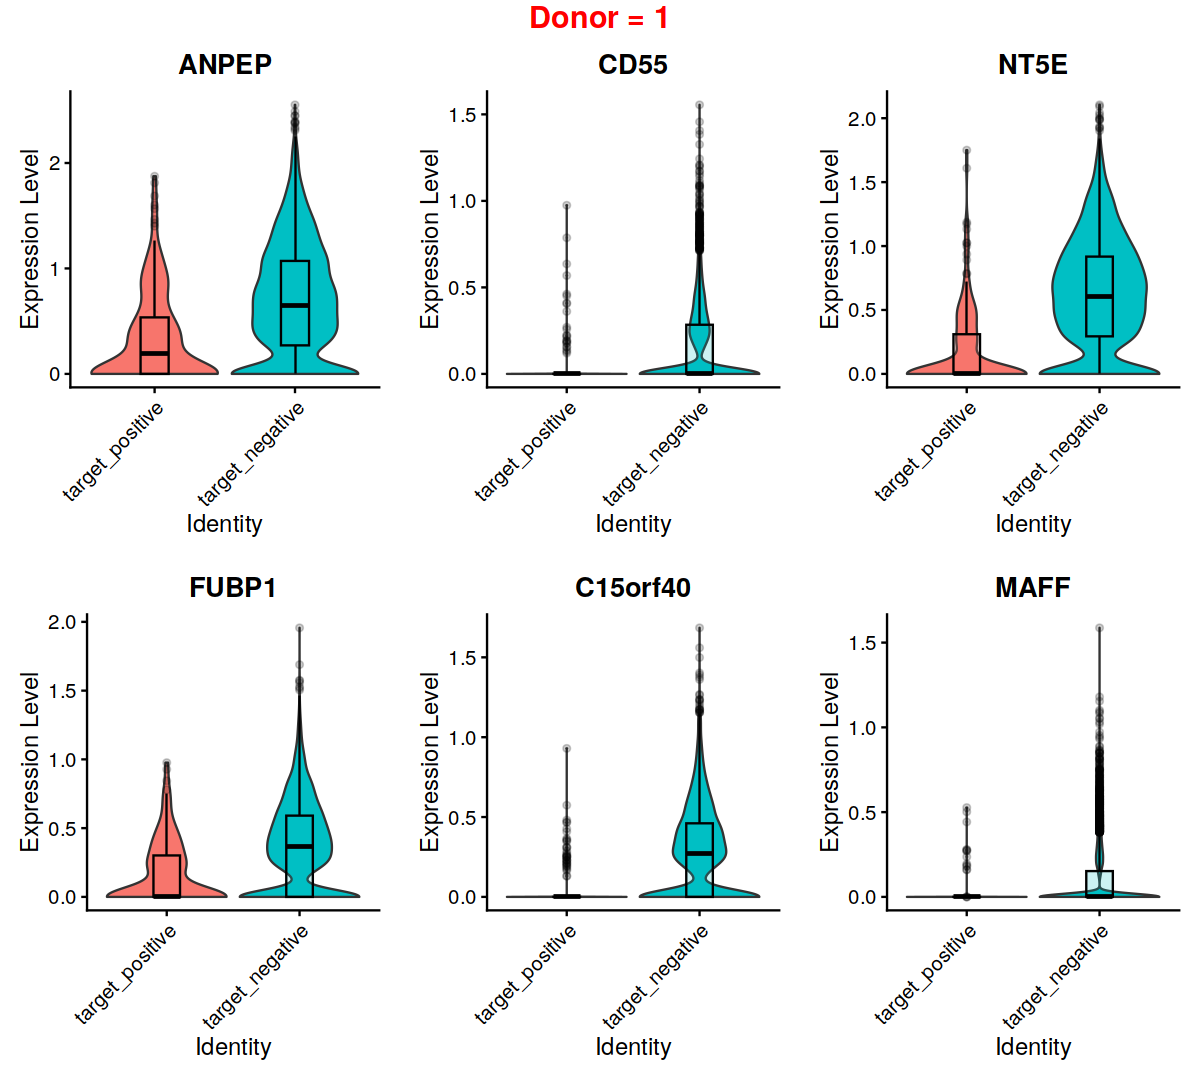

[1] "ANPEP"
CD13-1a   210 
CD13-1b   273 
Guide+ = 273 ; Guide- = 5971 
[1] "CD55"
CD55-1a   218 
CD55-1b   289 
Guide+ = 289 ; Guide- = 5955 
[1] "NT5E"
CD73-1a   174 
CD73-1b   237 
Guide+ = 237 ; Guide- = 6007 
[1] "FUBP1"
FUBP1-1a   185 
FUBP1-1b   248 
Guide+ = 248 ; Guide- = 5996 
[1] "C15orf40"
C15orf40-1a   201 
C15orf40-1b   269 
Guide+ = 269 ; Guide- = 5975 
[1] "MAFF"
MAFF-1a   156 
MAFF-1b   209 
Guide+ = 209 ; Guide- = 6035 


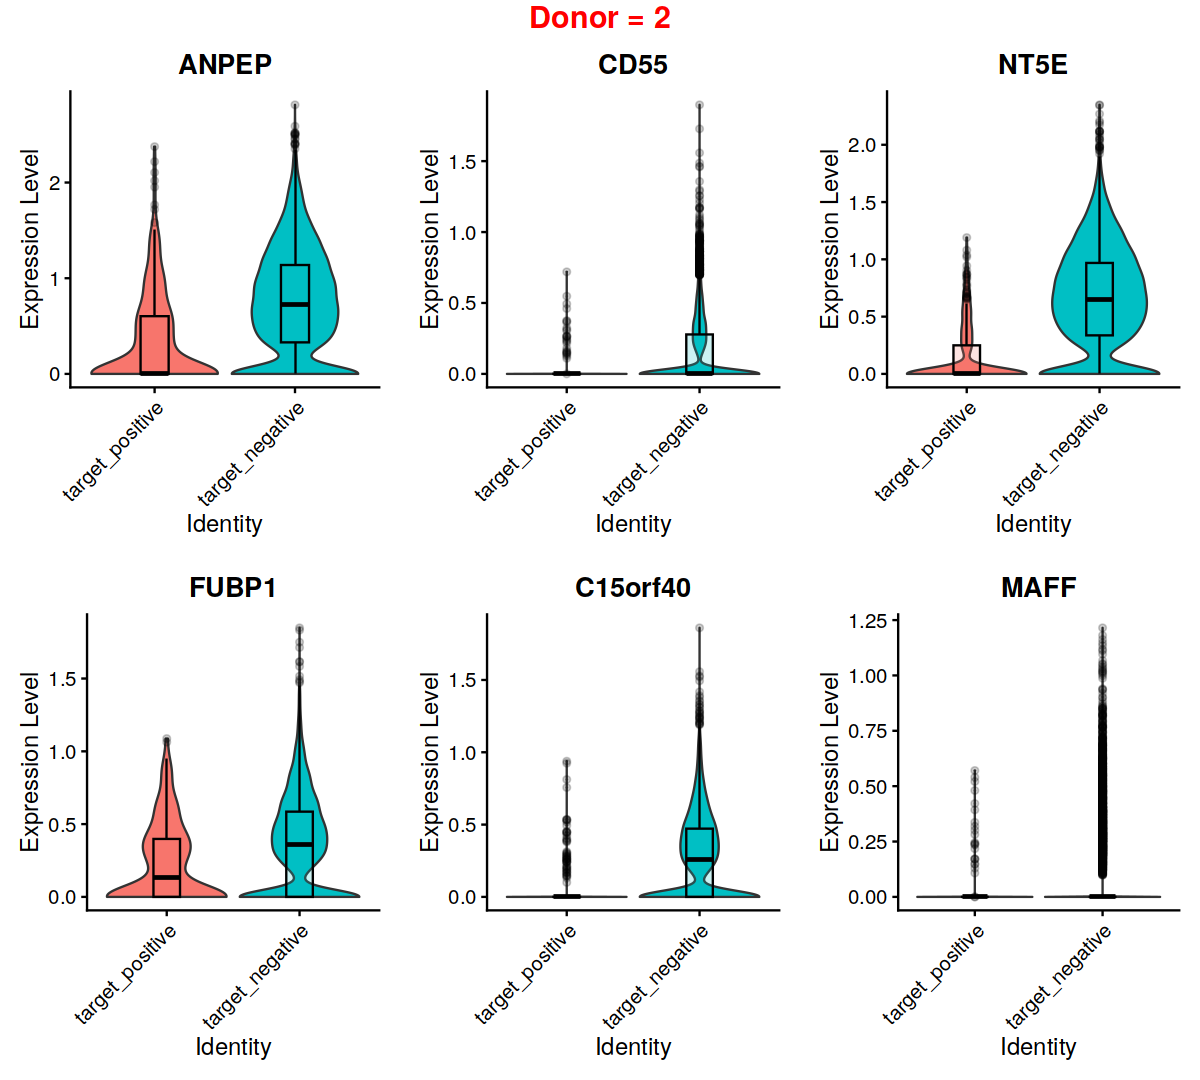

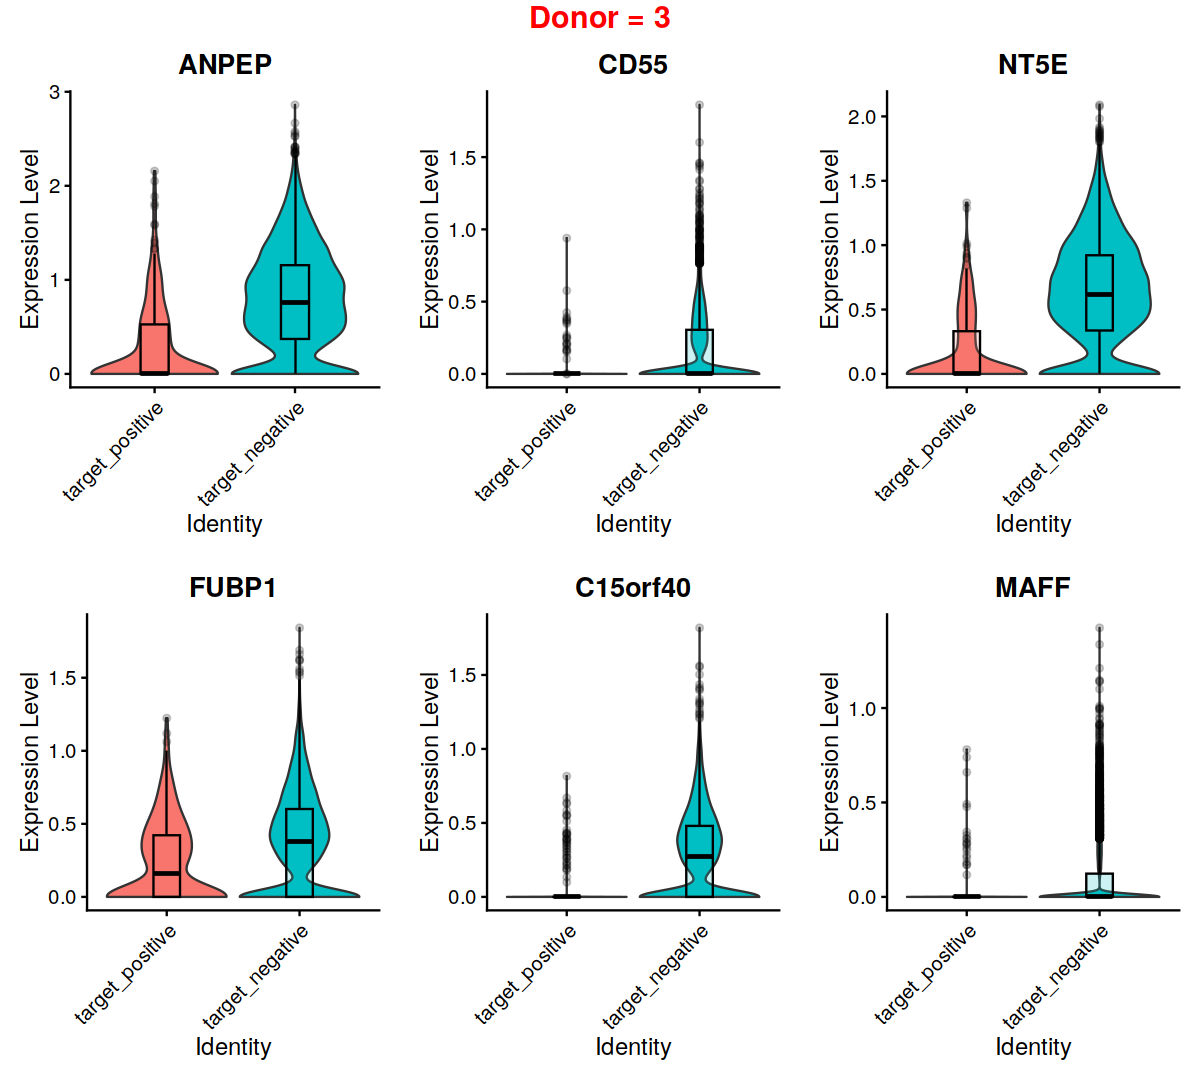

In [20]:
donors <- sort(unique(seurat_rna$donor))

for (donor_id in donors) {
    targets <- unique(filter(df_guide, subclass == "de_control")$alias)
    seurat_donor <- subset(seurat_rna, subset = donor == donor_id)
    perturbed_cells_by_guide <- get_perturbed_cells(
        seurat_combined,
        df_thresholds, donor_id
    )

    targets <- unique(filter(df_guide, subclass == "tss")$alias)
    plots <- vlnplot_for_targets(
        seurat_donor,
        df_guide,
        perturbed_cells_by_guide,
        targets
    )
    title <- paste0("Donor = ", donor_id)
    options(repr.plot.width = 10, repr.plot.height = 9)
    p <- ggarrange(plotlist = plots, ncol = 3, nrow = 2)
    p <- annotate_figure(
        p,
        top = text_grob(title, color = "red", face = "bold", size = 18)
    )
    print(p)
}


## DE controls

[1] "FTH1"
FTH1-1a   126 
FTH1-2a   798 
FTH1-1b   843 
FTH1-2b   843 
Guide+ = 843 ; Guide- = 6171 
[1] "PLIN3"
PLIN3-1a   184 
PLIN3-2a   365 
PLIN3-1b   423 
PLIN3-2b   476 
Guide+ = 476 ; Guide- = 6538 
[1] "TKT"
TKT-1a   173 
TKT-2a   366 
TKT-1b   414 
TKT-2b   475 
Guide+ = 475 ; Guide- = 6539 
[1] "LGALS3"
LGALS3-1a   244 
LGALS3-2a   443 
LGALS3-1b   491 
LGALS3-2b   542 
Guide+ = 542 ; Guide- = 6472 
[1] "CSTB"
CSTB-1a   215 
CSTB-2a   410 
CSTB-1b   477 
CSTB-2b   543 
Guide+ = 543 ; Guide- = 6471 
[1] "CTSB"
CTSB-1a   226 
CTSB-2a   434 
CTSB-1b   492 
CTSB-2b   540 
Guide+ = 540 ; Guide- = 6474 
[1] "KLF6"
KLF6-1a   212 
KLF6-2a   411 
KLF6-1b   472 
KLF6-2b   526 
Guide+ = 526 ; Guide- = 6488 
[1] "FTH1"
FTH1-1a   132 
FTH1-2a   748 
FTH1-1b   789 
FTH1-2b   789 
Guide+ = 789 ; Guide- = 5023 
[1] "PLIN3"
PLIN3-1a   183 
PLIN3-2a   317 
PLIN3-1b   375 
PLIN3-2b   425 
Guide+ = 425 ; Guide- = 5387 
[1] "TKT"
TKT-1a   138 
TKT-2a   318 
TKT-1b   368 
TKT-2b   422 
Guide+ = 4

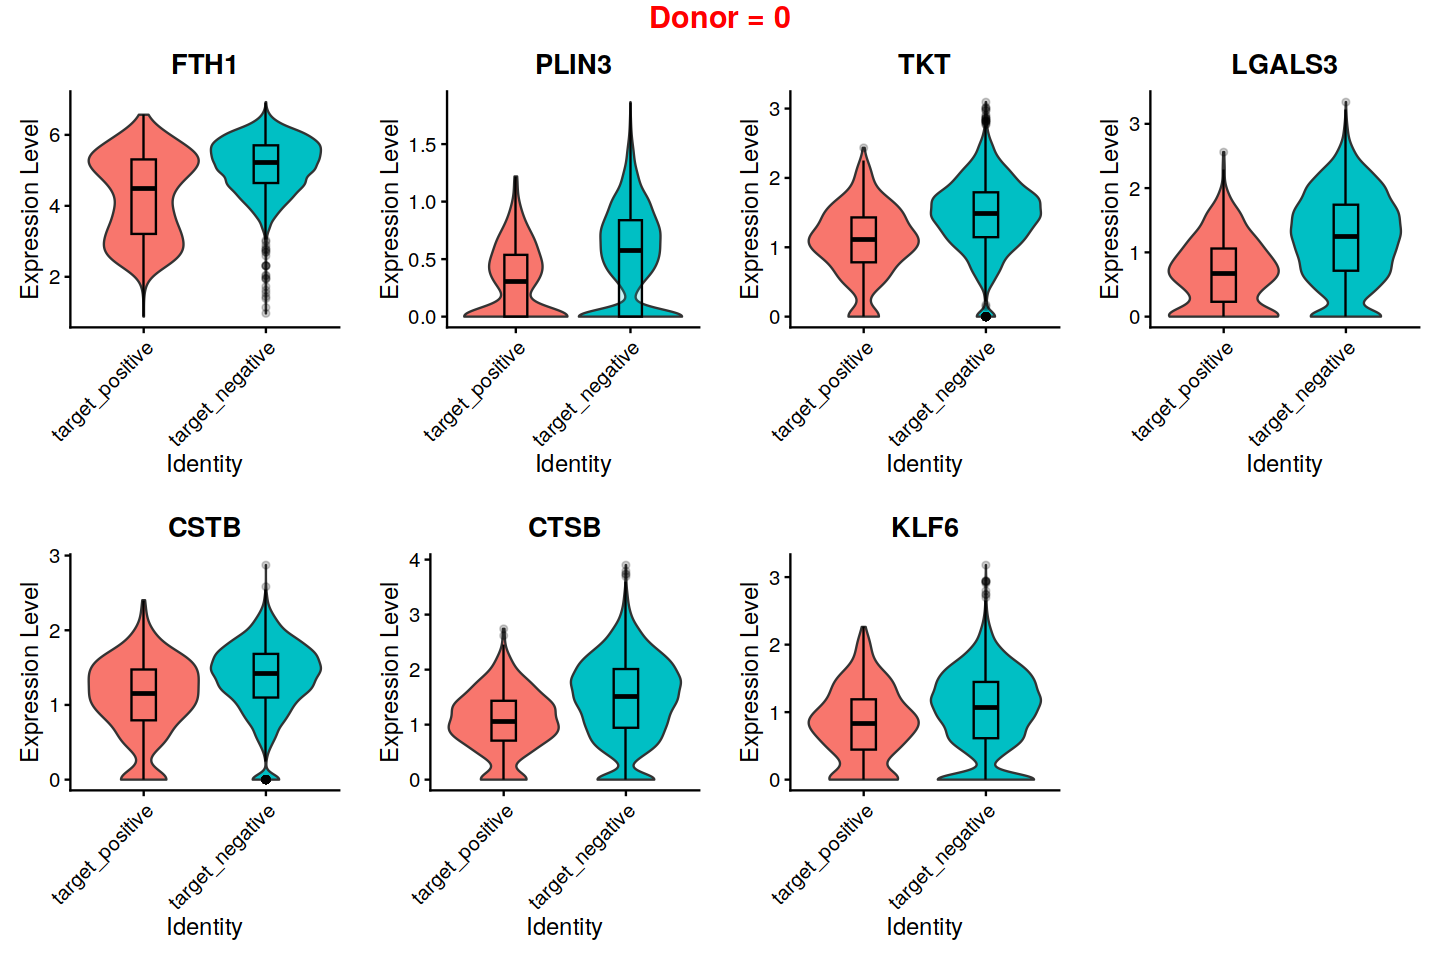

[1] "FTH1"
FTH1-1a   207 
FTH1-2a   995 
FTH1-1b   1037 
FTH1-2b   1037 
Guide+ = 1037 ; Guide- = 7035 
[1] "PLIN3"
PLIN3-1a   276 
PLIN3-2a   507 
PLIN3-1b   564 
PLIN3-2b   651 
Guide+ = 651 ; Guide- = 7421 
[1] "TKT"
TKT-1a   213 
TKT-2a   469 
TKT-1b   528 
TKT-2b   612 
Guide+ = 612 ; Guide- = 7460 
[1] "LGALS3"
LGALS3-1a   266 
LGALS3-2a   492 
LGALS3-1b   575 
LGALS3-2b   646 
Guide+ = 646 ; Guide- = 7426 
[1] "CSTB"
CSTB-1a   299 
CSTB-2a   565 
CSTB-1b   637 
CSTB-2b   713 
Guide+ = 713 ; Guide- = 7359 
[1] "CTSB"
CTSB-1a   311 
CTSB-2a   553 
CTSB-1b   624 
CTSB-2b   668 
Guide+ = 668 ; Guide- = 7404 
[1] "KLF6"
KLF6-1a   275 
KLF6-2a   532 
KLF6-1b   600 
KLF6-2b   667 
Guide+ = 667 ; Guide- = 7405 


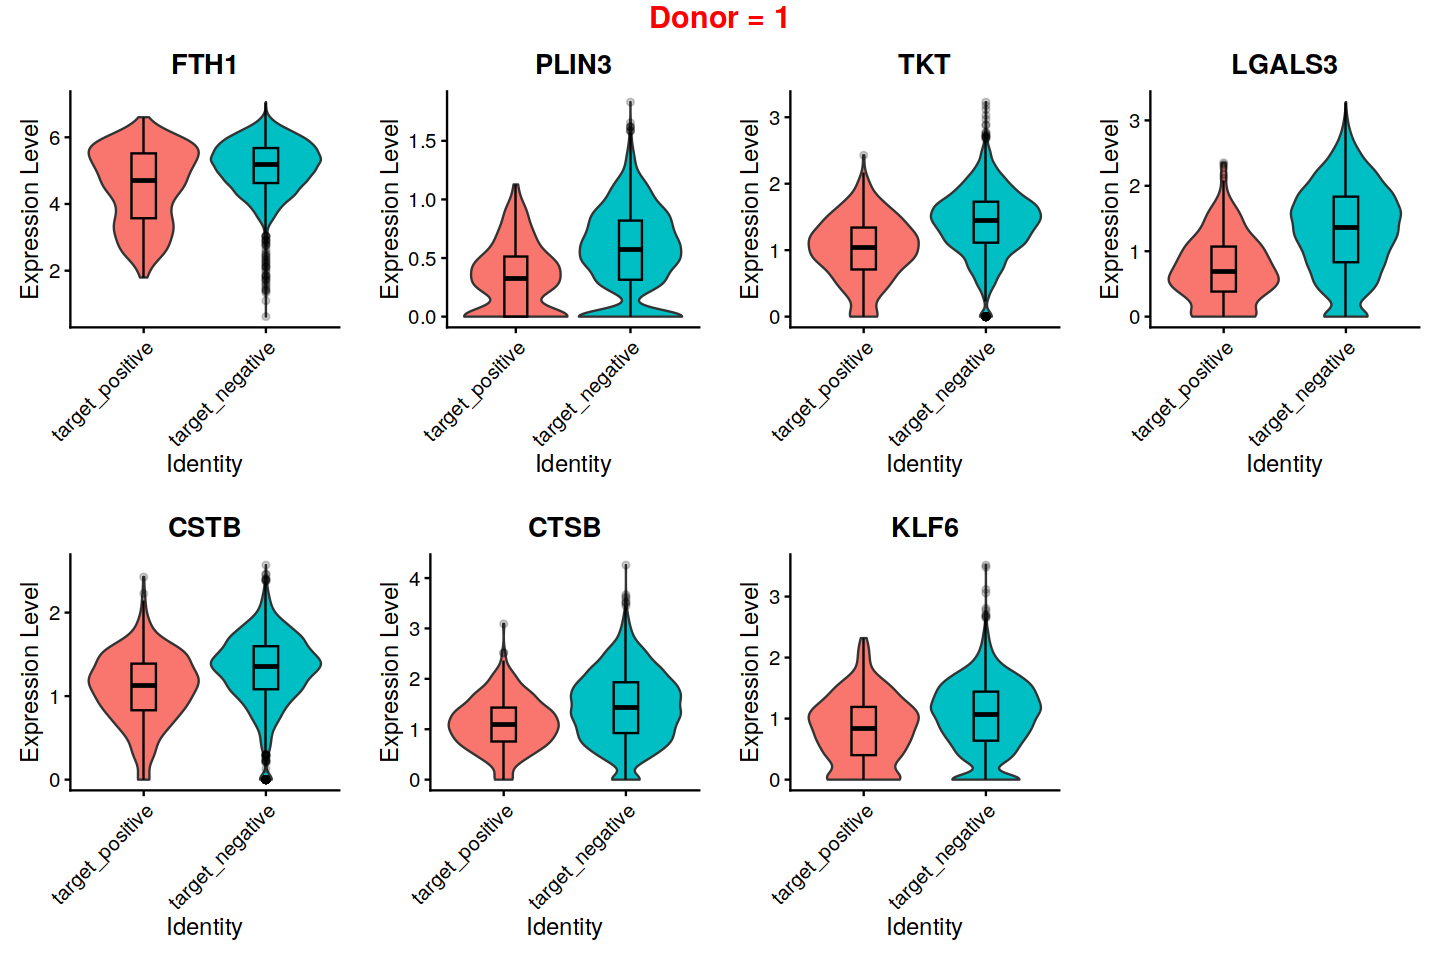

[1] "FTH1"
FTH1-1a   160 
FTH1-2a   788 
FTH1-1b   833 
FTH1-2b   833 
Guide+ = 833 ; Guide- = 5411 
[1] "PLIN3"
PLIN3-1a   220 
PLIN3-2a   393 
PLIN3-1b   455 
PLIN3-2b   504 
Guide+ = 504 ; Guide- = 5740 
[1] "TKT"
TKT-1a   150 
TKT-2a   343 
TKT-1b   396 
TKT-2b   467 
Guide+ = 467 ; Guide- = 5777 
[1] "LGALS3"
LGALS3-1a   231 
LGALS3-2a   394 
LGALS3-1b   457 
LGALS3-2b   523 
Guide+ = 523 ; Guide- = 5721 
[1] "CSTB"
CSTB-1a   242 
CSTB-2a   465 
CSTB-1b   527 
CSTB-2b   588 
Guide+ = 588 ; Guide- = 5656 
[1] "CTSB"
CTSB-1a   251 
CTSB-2a   441 
CTSB-1b   498 
CTSB-2b   560 
Guide+ = 560 ; Guide- = 5684 
[1] "KLF6"
KLF6-1a   215 
KLF6-2a   431 
KLF6-1b   492 
KLF6-2b   538 
Guide+ = 538 ; Guide- = 5706 


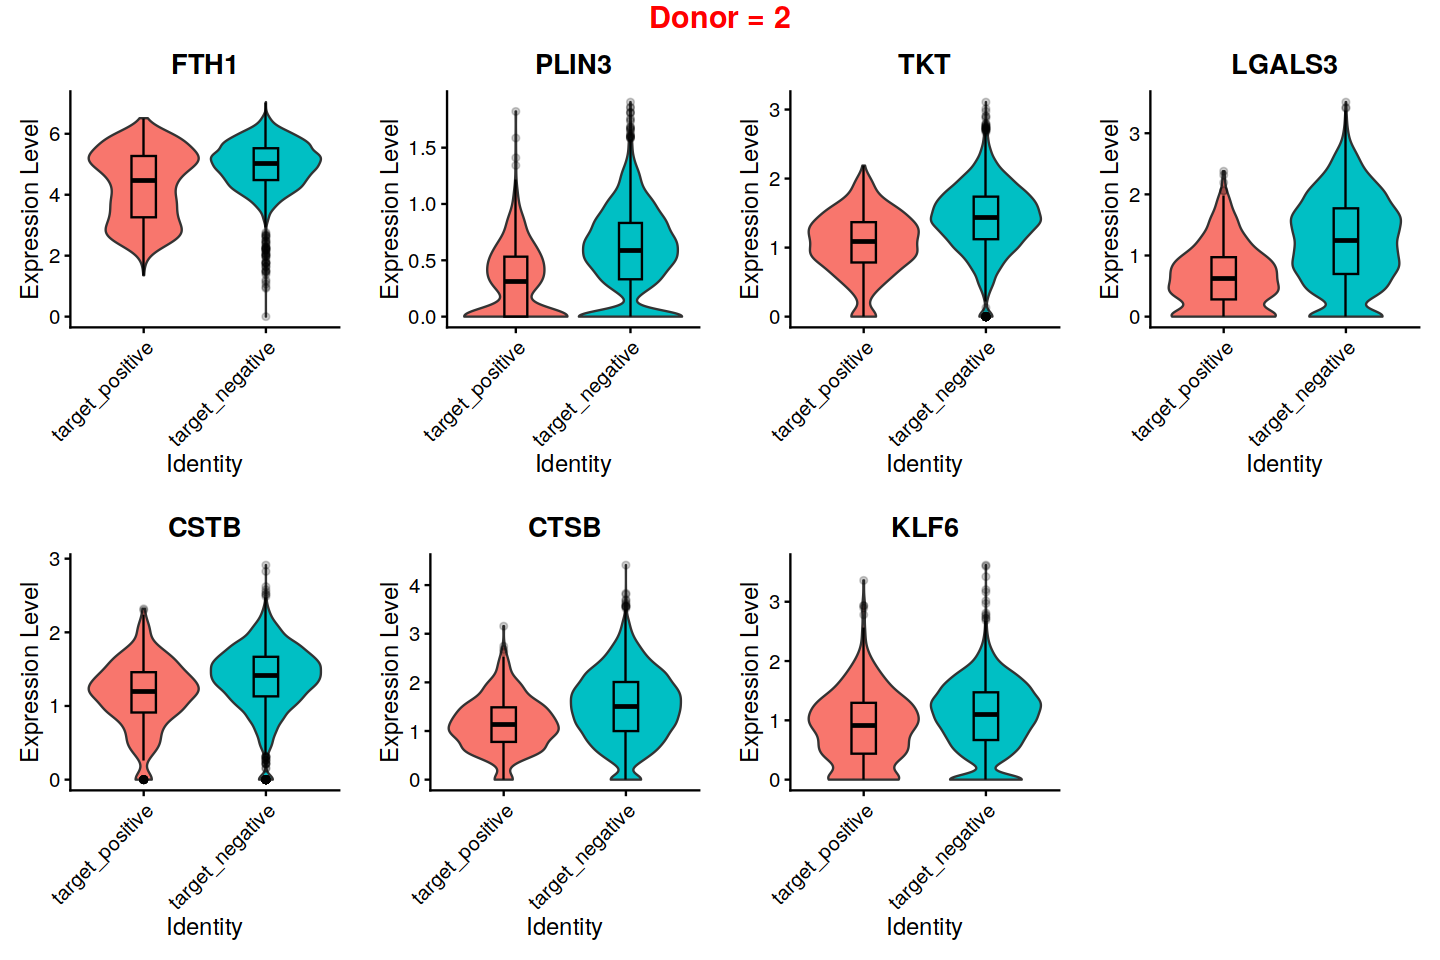

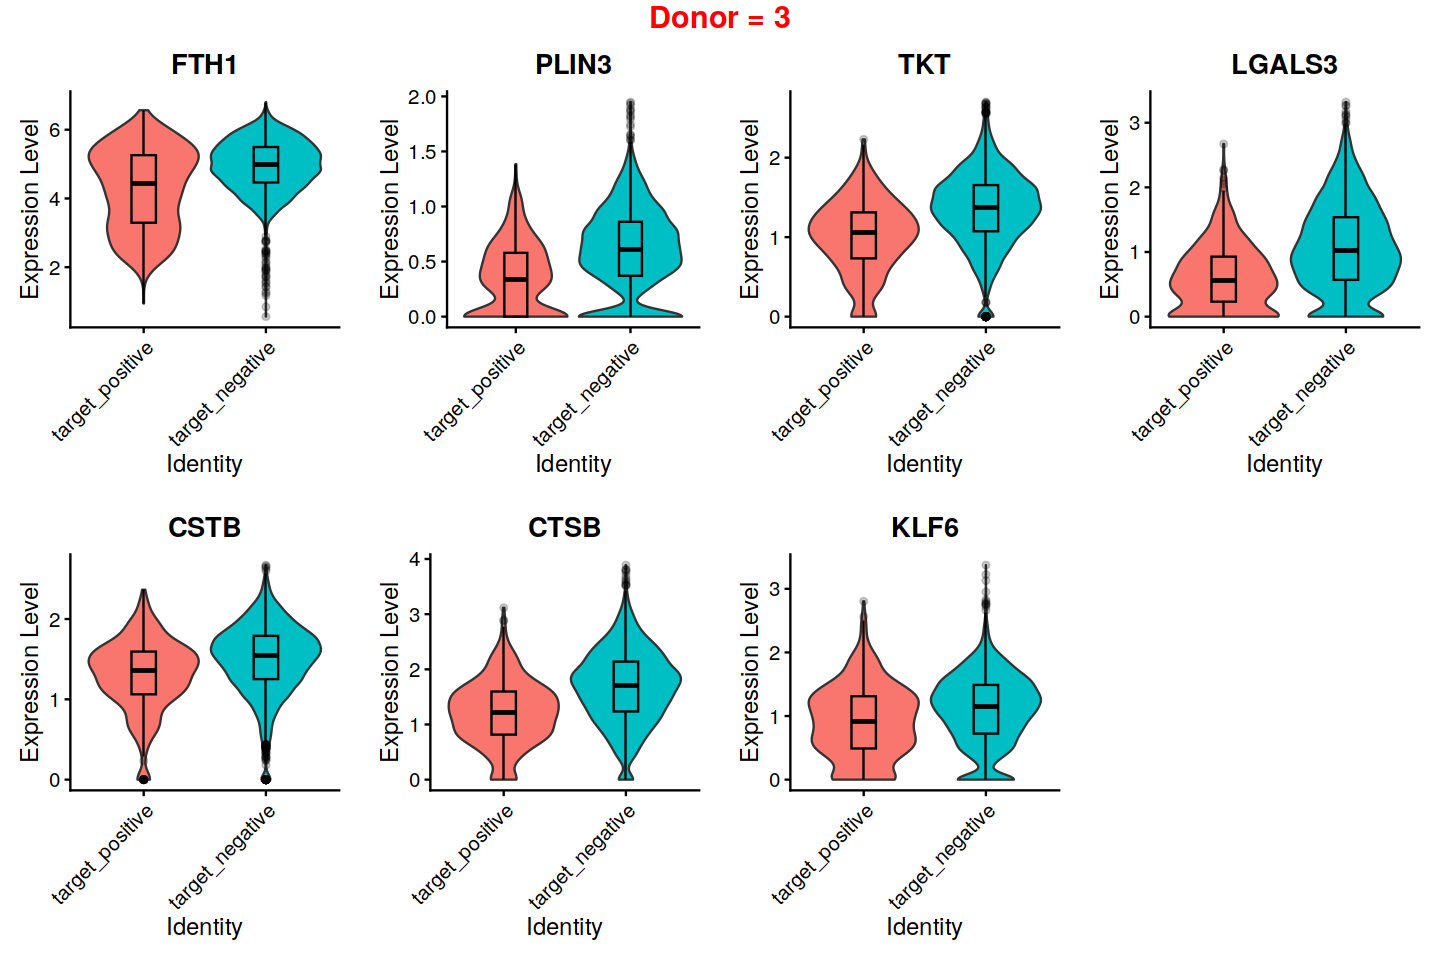

In [21]:
donors <- sort(unique(seurat_rna$donor))

for (donor_id in donors) {
    targets <- unique(filter(df_guide, subclass == "de_control")$alias)
    seurat_donor <- subset(seurat_rna, subset = donor == donor_id)
    perturbed_cells_by_guide <- get_perturbed_cells(
        seurat_combined,
        df_thresholds, donor_id
    )

    plots <- vlnplot_for_targets(
        seurat_donor, df_guide,
        perturbed_cells_by_guide,
        targets
    )
    title <- paste0("Donor = ", donor_id)
    options(repr.plot.width = 12, repr.plot.height = 8)
    p <- ggarrange(plotlist = plots, ncol = 4, nrow = 2)
    p <- annotate_figure(p,
        top = text_grob(title, color = "red", face = "bold", size = 18)
    )
    print(p)
}


## CKD DE 

Adding an extra gene or two the regulated_genes list to use as controls

[1] "DE6"
DE6-1a   221 
DE6-2a   643 
DE6-1b   695 
DE6-2b   699 
Guide+ = 699 ; Guide- = 6315 
[1] "DE6"
DE6-1a   187 
DE6-2a   537 
DE6-1b   581 
DE6-2b   583 
Guide+ = 583 ; Guide- = 5229 


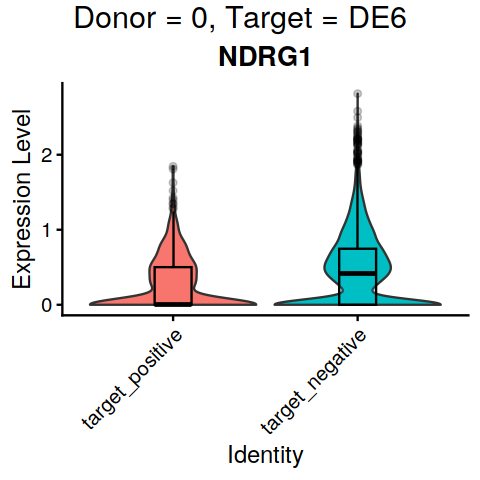

[1] "DE6"
DE6-1a   263 
DE6-2a   753 
DE6-1b   835 
DE6-2b   836 
Guide+ = 836 ; Guide- = 7236 


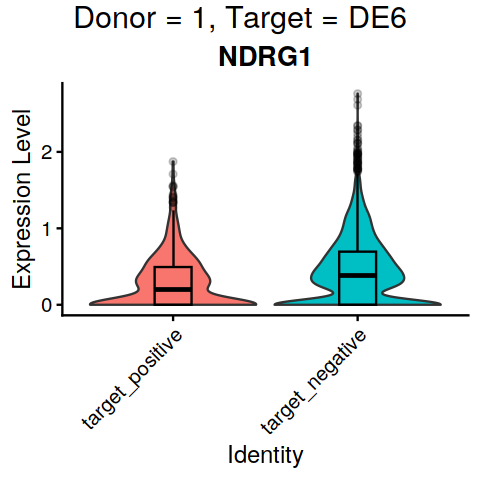

[1] "DE6"
DE6-1a   225 
DE6-2a   652 
DE6-1b   717 
DE6-2b   721 
Guide+ = 721 ; Guide- = 5523 


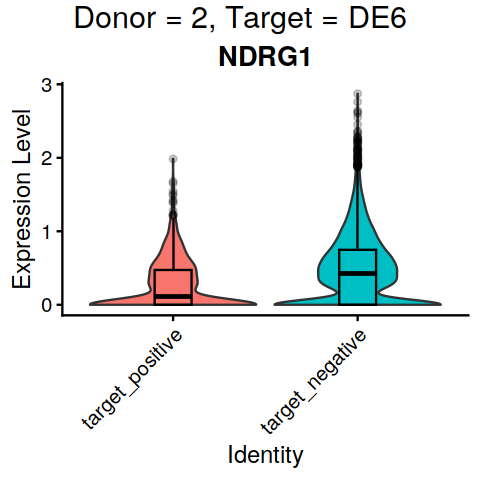

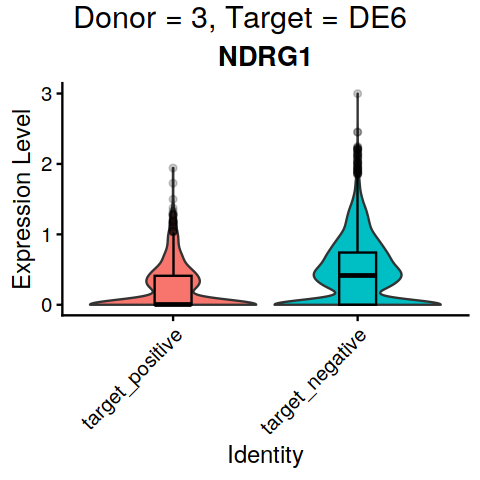

In [22]:
targets <- c("DE6")
regulated_genes <- c("NDRG1")

donors <- sort(unique(seurat_rna$donor))

for (donor_id in donors) {
    seurat_donor <- subset(seurat_rna, subset = donor == donor_id)
    perturbed_cells_by_guide <- get_perturbed_cells(
        seurat_combined,
        df_thresholds, donor_id
    )

    for (i in seq_along(targets)) {
        target <- targets[i]
        title <- paste0("Donor = ", donor_id, ", Target = ", target)
        print(target)
        guides <- get_guides_by_subclass(df_guide, "alias", target)
        seurat_donor <- mark_target_pos_neg(
            seurat_donor,
            perturbed_cells_by_guide,
            guides,
            print_counts = T
        )

        options(repr.plot.width = 3, repr.plot.height = 4)
        plots <- VlnPlot(
            object = seurat_donor,
            features = regulated_genes,
            idents = NULL,
            pt.size = 0,
            sort = F,
            ncol = 1,
            combine = F
        )

        for (i in 1:length(plots)) {
            plots[[i]] <- plots[[i]] +
                NoLegend() +
                geom_boxplot(width = .2, color = "black", alpha = 0.2)
        }
        plt1 <- ggarrange(plotlist = plots, ncol = 1, nrow = 1)
        plt1 <- annotate_figure(
            plt1,
            top = text_grob(title, color = "black", size = 18)
        )

        options(repr.plot.width = 4, repr.plot.height = 4)
        print(plt1)
        # print(plt2)
    }
}


[1] "DE15"
DE15-1a   205 
DE15-2a   430 
DE15-1b   488 
DE15-2b   553 
Guide+ = 553 ; Guide- = 6461 
[1] "DE15"
DE15-1a   179 
DE15-2a   366 
DE15-1b   413 
DE15-2b   475 
Guide+ = 475 ; Guide- = 5337 


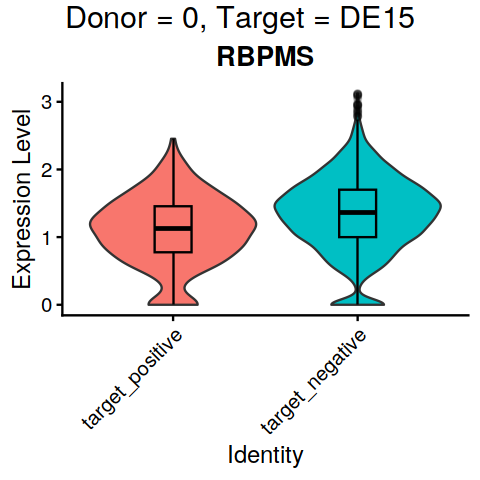

[1] "DE15"
DE15-1a   255 
DE15-2a   542 
DE15-1b   607 
DE15-2b   711 
Guide+ = 711 ; Guide- = 7361 


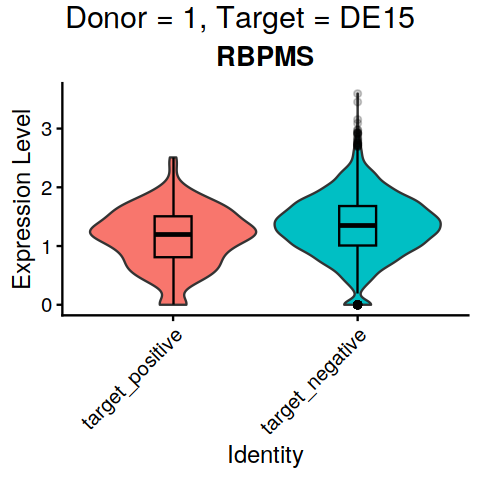

[1] "DE15"
DE15-1a   205 
DE15-2a   458 
DE15-1b   507 
DE15-2b   585 
Guide+ = 585 ; Guide- = 5659 


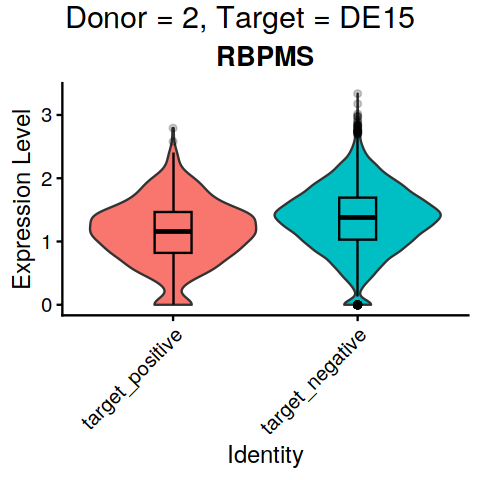

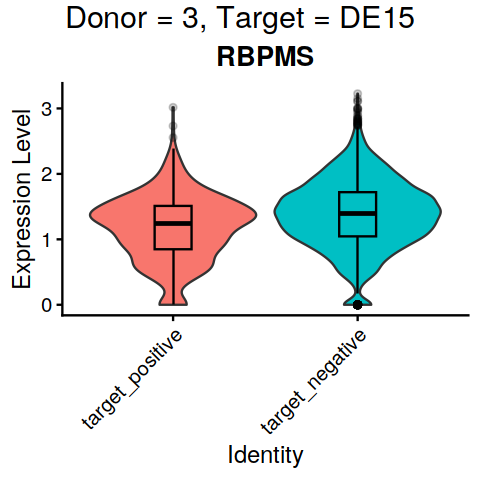

In [23]:
targets <- c("DE15")
regulated_genes <- c("RBPMS")

for (donor_id in donors) {
    seurat_donor <- subset(seurat_rna, subset = donor == donor_id)
    perturbed_cells_by_guide <- get_perturbed_cells(
        seurat_combined,
        df_thresholds, donor_id
    )

    for (i in seq_along(targets)) {
        target <- targets[i]
        title <- paste0("Donor = ", donor_id, ", Target = ", target)
        print(target)
        guides <- get_guides_by_subclass(df_guide, "alias", target)
        seurat_donor <- mark_target_pos_neg(
            seurat_donor,
            perturbed_cells_by_guide,
            guides,
            print_counts = T
        )

        options(repr.plot.width = 3, repr.plot.height = 4)
        plots <- VlnPlot(
            object = seurat_donor,
            features = regulated_genes,
            idents = NULL,
            pt.size = 0,
            sort = F,
            ncol = 1,
            combine = F
        )

        for (i in 1:length(plots)) {
            plots[[i]] <- plots[[i]] +
                NoLegend() +
                geom_boxplot(width = .2, color = "black", alpha = 0.2)
        }
        plt1 <- ggarrange(plotlist = plots, ncol = 1, nrow = 1)
        plt1 <- annotate_figure(plt1,
            top = text_grob(title, color = "black", size = 18)
        )

        options(repr.plot.width = 4, repr.plot.height = 4)
        print(plt1)
    }
}


In [24]:
print(df_de %>% filter(donor == donor_id) %>% arrange(p_val_adj))


       p_val avg_log2FC pct.1 pct.2 p_val_adj   de_gene   target donor
1   2.8e-102     -0.494 1.000  1.00   1.0e-97      FTH1     FTH1     3
2    2.9e-64     -0.703 0.367  0.82   1.1e-59      NT5E     NT5E     3
3    8.9e-59     -0.737 0.946  0.98   3.3e-54      CTSB     CTSB     3
4    1.6e-58     -0.803 0.769  0.90   6.0e-54    LGALS3   LGALS3     3
5    3.4e-53     -0.376 0.152  0.62   1.2e-48  C15orf40 C15orf40     3
6    5.3e-51     -0.731 0.443  0.82   1.9e-46     ANPEP    ANPEP     3
7    5.5e-49     -0.498 0.942  0.98   2.0e-44       TKT      TKT     3
8    6.8e-47     -0.380 0.681  0.84   2.5e-42     PLIN3    PLIN3     3
9    8.1e-47     -0.407 0.487  0.69   3.0e-42     NDRG1      DE6     3
10   2.5e-35     -0.236 0.076  0.40   9.0e-31      CD55     CD55     3
11   1.3e-26     -0.286 0.971  0.99   4.8e-22      CSTB     CSTB     3
12   1.1e-18     -0.312 0.956  0.97   3.9e-14     RBPMS     DE15     3
13   3.2e-13      0.171 1.000  1.00   1.2e-08     RPL36    PLIN3     3
14   1